# Initializing

In [47]:
#@title Installing libraries & packages
!pip install yfinance textblob vaderSentiment lazypredict scikit-learn pandas numpy matplotlib seaborn --quiet

import re
import pandas as pd
import numpy as np
import yfinance as yf
import datetime
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from lazypredict.Supervised import LazyRegressor, LazyClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [48]:
#@title Uploading raw data


with open("/content/tesla_2_headlines_nicely_formatted.txt", 'r', encoding='utf-8') as f:
    aditya_headlines_string = f.read()

    HEADLINES = aditya_headlines_string




In [49]:
#@title Parsing Headlines



KEYWORDS = ['earnings', 'SEC', 'lawsuit', 'FSD', 'recall', 'profit', 'loss', 'battery fire', 'chip shortage','loss', 'drop', 'decline', 'plunge', 'fall', 'slump', 'downturn', 'downgrade',
    'cut', 'reduce', 'shortfall', 'weak', 'slowdown', 'bearish', 'selloff',
    'lawsuit', 'probe', 'investigation', 'recall', 'defect', 'delay', 'accident',
    'fire', 'crash', 'explosion', 'fraud', 'scandal', 'controversy',
    'complaint', 'fine', 'penalty', 'regulatory', 'sec', 'litigation',
    'chip shortage', 'supply issue', 'strike', 'layoff', 'job cuts', 'resignation',
    'competition', 'antitrust', 'inflation', 'interest rate hike', 'cost overrun',
    'bankruptcy', 'default', 'downtime', 'negative outlook','profit', 'growth', 'increase', 'record', 'beat estimates', 'upgrade',
    'surge', 'soar', 'rally', 'bullish', 'expansion', 'rebound', 'strong demand',
    'partnership', 'contract', 'investment', 'approval', 'launch', 'innovation',
    'delivery record', 'autonomy', 'breakthrough', 'efficiency', 'milestone',
    'production ramp', 'earnings beat']
KEYWORD_BOOST = 2.0  # How much to multiply sentiment if keyword present

USE_3DAYS = True
USE_5DAYS = True
STOCK = 'TSLA'
START_DATE = '2021-01-03'
END_DATE = datetime.datetime.today().strftime('%Y-%m-%d')

# 3. Parse Headlines
def parse_headlines(text):
    lines = text.strip().split('\n')
    records = []
    buff, date, source = "", None, None

    for line in lines:
        line = line.strip()
        if not line:
            continue

        # Detect start of a new headline (e.g., "1. Tesla ...")
        if re.match(r'^\d+\.', line):
            # Save previous record before starting a new one
            if buff and date is not None:
                records.append({'date': date, 'headline': buff.strip(), 'source': source})
            buff = re.sub(r'^\d+\.\s*', '', line).strip()
            date = None
            source = None # Reset source for the new headline

        elif line.startswith('Source:'):
            match = re.match(r'Source:\s*(.*)', line)
            if match:
                source = match.group(1).strip()

        elif line.startswith('Published on:'):
            match = re.search(r'(\d{2} \w{3} \d{4})', line)
            if match:
                date = pd.to_datetime(match.group(1), format='%d %b %Y')

        # This section is for continuation lines, ensure it doesn't pick up Source/Published
        elif not line.startswith('Source:') and not line.startswith('Published on:'):
            buff += " " + line.strip()

    # Add the last record
    if buff and date is not None:
        records.append({'date': date, 'headline': buff.strip(), 'source': source})

    return pd.DataFrame(records)

news_df = parse_headlines(HEADLINES)
# Ensure news_df has both date and source columns before dropping NA
news_df = news_df.dropna(subset=['date', 'source']).sort_values('date').reset_index(drop=True)
print(f"Parsed {len(news_df)} headlines with dates and sources.")
display(news_df.head())

Parsed 300 headlines with dates and sources.


,date,headline,source
0,2021-01-04,EVs on a roll - 2020 has been rough for indust...,bangkokpost.com
1,2021-01-07,Electric Vehicles This Week: India’s Electric ...,inc42.com
2,2021-02-02,Elon Musk Shares Video Showing Gigafactory Ber...,benzinga.com
3,2021-02-03,Telangana transport department announces incen...,thehindubusinessline.com
4,2021-02-04,Could Tesla's Gigafactory Berlin Produce Over ...,benzinga.com


In [50]:
#@title Sentiment Analysis
analyzer = SentimentIntensityAnalyzer()

def calc_sentiments(row):
    text = row['headline']
    vs = analyzer.polarity_scores(text)
    vader_score = vs['compound']
    tb_score = TextBlob(text).sentiment.polarity
    amplify = any(kw.lower() in text.lower() for kw in KEYWORDS)
    boost = KEYWORD_BOOST if amplify else 1.0
    vader_score *= boost
    tb_score *= boost
    return pd.Series({'vader': vader_score, 'textblob': tb_score})

news_df[['vader', 'textblob']] = news_df.apply(calc_sentiments, axis=1)
news_df['sentiment'] = 0.5 * news_df['vader'] + 0.5 * news_df['textblob']



In [51]:
#@title Fetching Stock Data
df = yf.download(STOCK, start=START_DATE, end=END_DATE)

# Flatten multi-level columns if needed
if isinstance(df.columns, pd.MultiIndex):
    df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]

df = df.reset_index()
df['Date'] = pd.to_datetime(df['Date'])

# Ensure consistent columns
expected_cols = ["Date", "Open", "High", "Low", "Close", "Volume"]
if "Adj Close" in df.columns:
    expected_cols.append("Adj Close")

df = df[expected_cols]

# Rename for merge
df = df.rename(columns={'Date': 'date'})

# Ensure same dtype for merge
df['date'] = pd.to_datetime(df['date'])
news_df['date'] = pd.to_datetime(news_df['date'])



[*********************100%***********************]  1 of 1 completed


In [52]:
#@title Performing Source Analysis and adding impact scores
sent_daily_overall = (
    news_df.groupby('date')
    .agg({
        'sentiment': 'mean',
    })
    .reset_index()
)

# Calculate rolling sentiment on the overall daily sentiment
if USE_3DAYS:
    sent_daily_overall['sent_3d'] = sent_daily_overall['sentiment'].rolling(window=3, min_periods=1).mean()
if USE_5DAYS:
    sent_daily_overall['sent_5d'] = sent_daily_overall['sentiment'].rolling(window=5, min_periods=1).mean()


# Source Impact Analysis & Daily Source-Specific Sentiment Features
print("\n" + "="*70)
print("ANALYZING WHICH SOURCES AFFECT STOCK PRICES MORE HEAVILY & CREATING SOURCE FEATURES")
print("="*70)

# Calculate stock price changes in the main df
df['pct_change'] = df['Close'].pct_change() * 100
df['next_day_change'] = df['pct_change'].shift(-1)

# Merge news with stock data for source impact analysis (dropna on next_day_change needed here)
news_with_prices_for_impact = pd.merge(news_df, df[['date', 'next_day_change']],
                             on='date', how='left').dropna(subset=['next_day_change'])

# Calculate impact metrics per source (using news_with_prices_for_impact)
from scipy.stats import pearsonr, spearmanr
source_impact = []

for source in news_with_prices_for_impact['source'].unique():
    if pd.isna(source):
        continue

    source_data = news_with_prices_for_impact[news_with_prices_for_impact['source'] == source].copy()

    if len(source_data) < 5:  # Need minimum data points for correlation
        continue

    # Correlation between sentiment and next-day price change
    # Ensure sentiment and next_day_change columns exist and are numeric in the source_data
    if 'sentiment' in source_data.columns and 'next_day_change' in source_data.columns:
        source_data['sentiment'] = pd.to_numeric(source_data['sentiment'], errors='coerce')
        source_data['next_day_change'] = pd.to_numeric(source_data['next_day_change'], errors='coerce')
        source_data.dropna(subset=['sentiment', 'next_day_change'], inplace=True) # Drop rows where conversion failed

        if len(source_data) > 1: # Need at least 2 data points for correlation
            corr_pearson, p_pearson = pearsonr(source_data['sentiment'], source_data['next_day_change'])
            corr_spearman, p_spearman = spearmanr(source_data['sentiment'], source_data['next_day_change'])
        else:
             corr_pearson, p_pearson = np.nan, np.nan
             corr_spearman, p_spearman = np.nan, np.nan
    else:
        corr_pearson, p_pearson = np.nan, np.nan
        corr_spearman, p_spearman = np.nan, np.nan


    # Average absolute price change following this source's headlines
    avg_abs_change = source_data['next_day_change'].abs().mean()

    # Directional accuracy: does sentiment sign match price movement sign?
    sentiment_direction = (source_data['sentiment'] > 0).astype(int)
    price_direction = (source_data['next_day_change'] > 0).astype(int)
    directional_accuracy = (sentiment_direction == price_direction).mean()

    # Average sentiment magnitude
    avg_sentiment_magnitude = source_data['sentiment'].abs().mean()

    # Weighted impact score (correlation * frequency * avg_change) - use absolute correlation
    impact_score = abs(corr_pearson) * len(source_data) * avg_abs_change if not np.isnan(corr_pearson) else 0

    source_impact.append({
        'source': source,
        'headline_count': len(source_data),
        'pearson_corr': corr_pearson,
        'p_value': p_pearson,
        'spearman_corr': corr_spearman, # Corrected typo here
        'avg_abs_price_change': avg_abs_change,
        'directional_accuracy': directional_accuracy,
        'avg_sentiment_magnitude': avg_sentiment_magnitude,
        'impact_score': impact_score,
        'significant': 'Yes' if not np.isnan(p_pearson) and p_pearson < 0.05 else 'No'
    })

impact_df = pd.DataFrame(source_impact).dropna(subset=['pearson_corr']).sort_values('impact_score', ascending=False).reset_index(drop=True)

print("\n📊 SOURCE IMPACT RANKING (by Impact Score)")
print("Impact Score = |Correlation| × Headline Count × Avg Price Change\n")
display(impact_df)

# Select top N sources to create daily features for (e.g., top 5 or those with significant correlation)
# Using a threshold for headline count and significance, or just top N based on impact score
TOP_N_SOURCES = 5
top_sources_list = impact_df.head(TOP_N_SOURCES)['source'].tolist()
print(f"\nCreating daily sentiment features for top {TOP_N_SOURCES} sources:")
print(top_sources_list)

# Create daily sentiment features for selected sources
source_daily_sentiments = news_df[news_df['source'].isin(top_sources_list)].groupby(['date', 'source'])['sentiment'].mean().unstack(fill_value=0)

# Flatten column names
source_daily_sentiments.columns = [f'sent_{c.replace(".", "_").replace(" ", "_")}' for c in source_daily_sentiments.columns]

# --- Add new feature: Average Source Impact Score per Day ---
# Merge news_df with impact_df to get impact score for each headline
news_with_impact = pd.merge(news_df, impact_df[['source', 'impact_score']], on='source', how='left')

# Calculate average impact score per day (only for days with headlines)
daily_avg_source_impact = news_with_impact.groupby('date')['impact_score'].mean().reset_index()
daily_avg_source_impact = daily_avg_source_impact.rename(columns={'impact_score': 'avg_source_impact_daily'})

# 8. Merge Sentiment (Overall and Source-Specific) and Daily Average Source Impact with Stock Data
full = pd.merge(df, sent_daily_overall, how='left', on='date')
full = pd.merge(full, source_daily_sentiments, how='left', on='date')
full = pd.merge(full, daily_avg_source_impact, how='left', on='date') # Merge the new feature

# Fill missing sentiment values (days with no headlines) with 0
sentiment_cols = [col for col in full.columns if col.startswith('sent_')]
full[sentiment_cols] = full[sentiment_cols].fillna(0)
full['avg_source_impact_daily'] = full['avg_source_impact_daily'].fillna(0) # Fill missing impact scores for days with no news

# Final check on the 'full' dataframe
full = full.fillna(0) # Fill any remaining NaNs, e.g., from rolling averages at the start

print("\n✓ Merged data with daily overall, source-specific sentiment, and average source impact:")
display(full.head())


ANALYZING WHICH SOURCES AFFECT STOCK PRICES MORE HEAVILY & CREATING SOURCE FEATURES

📊 SOURCE IMPACT RANKING (by Impact Score)
Impact Score = |Correlation| × Headline Count × Avg Price Change



,source,headline_count,pearson_corr,p_value,spearman_corr,avg_abs_price_change,directional_accuracy,avg_sentiment_magnitude,impact_score,significant
0,finance.yahoo.com,6,-0.96,0.00,-0.94,4.88,0.33,0.42,28.06,Yes
1,gurufocus.com,58,-0.14,0.31,-0.10,3.21,0.53,0.36,25.40,No
2,investing.com,9,0.53,0.14,0.37,3.26,0.67,0.18,15.52,No
3,forbes.com,7,-0.62,0.14,-0.89,3.28,0.43,0.32,14.26,No
4,seekingalpha.com,5,-0.57,0.32,-0.80,4.34,0.20,0.42,12.28,No
5,timesofindia.indiatimes.com,11,-0.21,0.54,-0.11,3.34,0.45,0.24,7.64,No
6,medium.com,12,0.18,0.57,0.31,2.28,0.50,0.42,4.95,No
7,benzinga.com,7,-0.30,0.51,-0.50,2.29,0.43,0.30,4.89,No
8,bangkokpost.com,16,0.08,0.76,0.08,3.33,0.75,0.38,4.37,No
9,cnbc.com,7,0.22,0.64,0.29,2.65,0.71,0.34,4.02,No



Creating daily sentiment features for top 5 sources:
['finance.yahoo.com', 'gurufocus.com', 'investing.com', 'forbes.com', 'seekingalpha.com']

✓ Merged data with daily overall, source-specific sentiment, and average source impact:


,date,Open,High,Low,Close,Volume,pct_change,next_day_change,sentiment,sent_3d,sent_5d,sent_finance_yahoo_com,sent_forbes_com,sent_gurufocus_com,sent_investing_com,sent_seekingalpha_com,avg_source_impact_daily
0,2021-01-04,239.82,248.16,239.06,243.26,145914600,0.00,0.73,0.59,0.59,0.59,0.00,0.00,0.00,0.00,0.00,4.37
1,2021-01-05,241.22,246.95,239.73,245.04,96735600,0.73,2.84,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,2021-01-06,252.83,258.00,249.70,251.99,134100000,2.84,7.94,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,2021-01-07,259.21,272.33,258.40,272.01,154496700,7.94,7.84,0.45,0.52,0.52,0.00,0.00,0.00,0.00,0.00,0.00
4,2021-01-08,285.33,294.83,279.46,293.34,225166500,7.84,-7.82,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [53]:
#@title Defining targets and features
# Ensure 'full' DataFrame is available and processed from the previous cell

# Define target variables
full['close_next'] = full['Close'].shift(-1)
full['pct_change'] = 100 * (full['close_next'] - full['Close']) / full['Close']
full['target'] = full['pct_change']
full['direction'] = (full['pct_change'] > 0).astype(int)

# Define feature columns - include overall and source-specific sentiments, and the new average source impact
feature_cols = ['sentiment'] # Overall daily sentiment
if USE_3DAYS: feature_cols.append('sent_3d')
if USE_5DAYS: feature_cols.append('sent_5d')

# Add dynamically created source-specific sentiment columns
source_sentiment_cols = [col for col in full.columns if col.startswith('sent_')
                         and col not in ['sentiment', 'sent_3d', 'sent_5d']]
feature_cols.extend(source_sentiment_cols)

# Add the new average source impact feature
feature_cols.append('avg_source_impact_daily')


print(f"Using features: {feature_cols}")

# Prepare X and y for modeling, removing the last row as target is NaN
X = full[feature_cols][:-1].copy() # Use .copy() to avoid SettingWithCopyWarning
y_reg = full['target'][:-1].copy()
y_cls = full['direction'][:-1].copy()

print("\nShape of feature matrix (X):", X.shape)
print("Shape of regression target (y_reg):", y_reg.shape)
print("Shape of classification target (y_cls):", y_cls.shape)

Using features: ['sentiment', 'sent_3d', 'sent_5d', 'sent_finance_yahoo_com', 'sent_forbes_com', 'sent_gurufocus_com', 'sent_investing_com', 'sent_seekingalpha_com', 'avg_source_impact_daily']

Shape of feature matrix (X): (1208, 9)
Shape of regression target (y_reg): (1208,)
Shape of classification target (y_cls): (1208,)


# Exploratory Data Analysis

## Calcs

In [54]:
#@title Overview

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

print("="*80)
print("EXPLORATORY DATA ANALYSIS - TESLA STOCK PRICE PREDICTOR")
print("="*80)
print()

print("1. DATASET OVERVIEW")
print("-"*80)
print(f"Total number of trading days: {len(full)}")
print(f"Date range: {full['date'].min().strftime('%Y-%m-%d')} to {full['date'].max().strftime('%Y-%m-%d')}")
print(f"Number of days with news headlines: {(full['sentiment'] != 0).sum()}")
print(f"Number of days without news: {(full['sentiment'] == 0).sum()}")
print(f"Missing values:\n{full.isnull().sum()}")
print()


EXPLORATORY DATA ANALYSIS - TESLA STOCK PRICE PREDICTOR

1. DATASET OVERVIEW
--------------------------------------------------------------------------------
Total number of trading days: 1209
Date range: 2021-01-04 to 2025-10-24
Number of days with news headlines: 190
Number of days without news: 1019
Missing values:
date                       0
Open                       0
High                       0
Low                        0
Close                      0
Volume                     0
pct_change                 1
next_day_change            0
sentiment                  0
sent_3d                    0
sent_5d                    0
sent_finance_yahoo_com     0
sent_forbes_com            0
sent_gurufocus_com         0
sent_investing_com         0
sent_seekingalpha_com      0
avg_source_impact_daily    0
close_next                 1
target                     1
direction                  0
dtype: int64



In [55]:
#@title Price stats

print("2. STOCK PRICE STATISTICS")
print("-"*80)
price_stats = full[['Open', 'High', 'Low', 'Close', 'Volume']].describe()
print(price_stats)
print()

print(f"Price volatility (std of daily returns): {full['pct_change'].std():.3f}%")
print(f"Average daily return: {full['pct_change'].mean():.3f}%")
print(f"Max daily gain: {full['pct_change'].max():.3f}%")
print(f"Max daily loss: {full['pct_change'].min():.3f}%")
print()

2. STOCK PRICE STATISTICS
--------------------------------------------------------------------------------
         Open    High     Low   Close       Volume
count 1209.00 1209.00 1209.00 1209.00      1209.00
mean   258.85  264.56  252.71  258.72 100509817.62
std     70.02   71.50   68.08   69.83  39494042.59
min    103.00  111.75  101.81  108.10  29401800.00
25%    209.50  214.66  204.82  208.80  71975500.00
50%    246.69  251.80  240.85  246.28  93634200.00
75%    300.00  307.04  292.45  299.98 119845100.00
max    475.90  488.54  457.51  479.86 306590600.00

Price volatility (std of daily returns): 3.858%
Average daily return: 0.122%
Max daily gain: 22.690%
Max daily loss: -15.426%



In [56]:
#@title Sentiment data stats

print("3. SENTIMENT ANALYSIS STATISTICS")
print("-"*80)
sent_data = full[full['sentiment'] != 0]
print(f"Days with sentiment data: {len(sent_data)}")
print(f"Average sentiment: {sent_data['sentiment'].mean():.4f}")
print(f"Sentiment std dev: {sent_data['sentiment'].std():.4f}")
print(f"Most positive sentiment: {sent_data['sentiment'].max():.4f}")
print(f"Most negative sentiment: {sent_data['sentiment'].min():.4f}")
print()

if USE_3DAYS:
    print(f"Average 3-day rolling sentiment: {sent_data['sent_3d'].mean():.4f}")
if USE_5DAYS:
    print(f"Average 5-day rolling sentiment: {sent_data['sent_5d'].mean():.4f}")
print()




3. SENTIMENT ANALYSIS STATISTICS
--------------------------------------------------------------------------------
Days with sentiment data: 190
Average sentiment: 0.2342
Sentiment std dev: 0.4002
Most positive sentiment: 1.8555
Most negative sentiment: -0.9747

Average 3-day rolling sentiment: 0.2310
Average 5-day rolling sentiment: 0.2286



In [57]:
#@title Target Distribution

print("4. TARGET VARIABLE ANALYSIS")
print("-"*80)
up_days = (full['direction'] == 1).sum()
down_days = (full['direction'] == 0).sum()
print(f"Up days (price increased): {up_days} ({100*up_days/len(full):.1f}%)")
print(f"Down/flat days: {down_days} ({100*down_days/len(full):.1f}%)")
print()

4. TARGET VARIABLE ANALYSIS
--------------------------------------------------------------------------------
Up days (price increased): 623 (51.5%)
Down/flat days: 586 (48.5%)



## Visualizations:

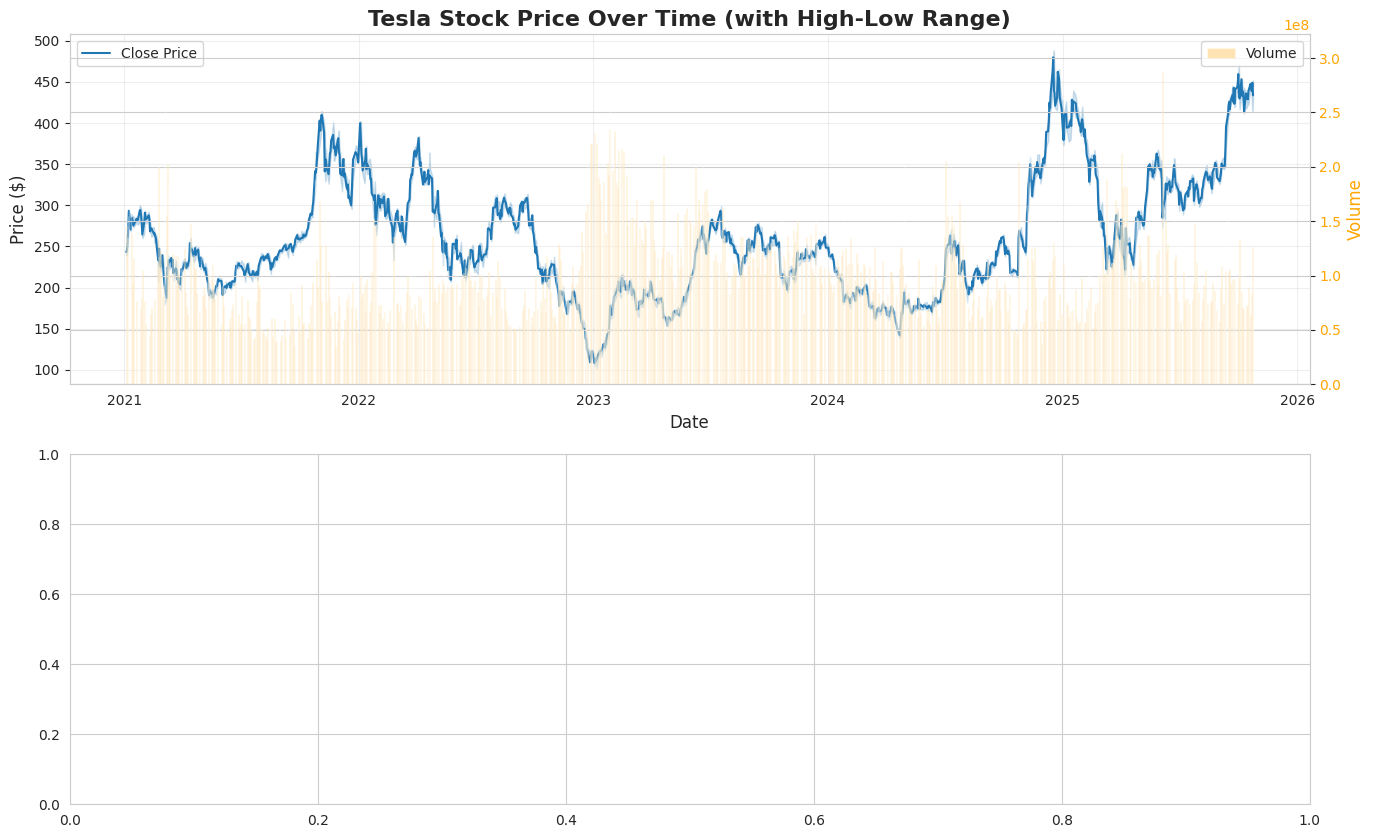

In [82]:
#@title Stock Price Over Time
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 1, figsize=(16, 10))

axes[0].plot(full['date'], full['Close'], color='#1f77b4', linewidth=1.5, label='Close Price')
axes[0].fill_between(full['date'], full['Low'], full['High'], alpha=0.2, color='#1f77b4')
axes[0].set_title('Tesla Stock Price Over Time (with High-Low Range)', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Date', fontsize=12)
axes[0].set_ylabel('Price ($)', fontsize=12)
axes[0].legend(loc='upper left')
axes[0].grid(True, alpha=0.3)

# Plot volume
ax2 = axes[0].twinx()
ax2.bar(full['date'], full['Volume'], alpha=0.3, color='orange', label='Volume')
ax2.set_ylabel('Volume', fontsize=12, color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
ax2.legend(loc='upper right')

# Save the plot
plt.savefig('stock_price_over_time.png')

In [83]:
#@title Daily Returns Distribution
import matplotlib.pyplot as plt

axes[1].hist(full['pct_change'].dropna(), bins=50, color='#2ca02c', alpha=0.7, edgecolor='black')
axes[1].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Return')
axes[1].axvline(full['pct_change'].mean(), color='blue', linestyle='--', linewidth=2, label=f'Mean: {full["pct_change"].mean():.2f}%')
axes[1].set_title('Distribution of Daily Returns', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Daily Return (%)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Save the plot
plt.savefig('daily_returns_distribution.png')

<Figure size 1400x800 with 0 Axes>

<Figure size 1400x800 with 0 Axes>

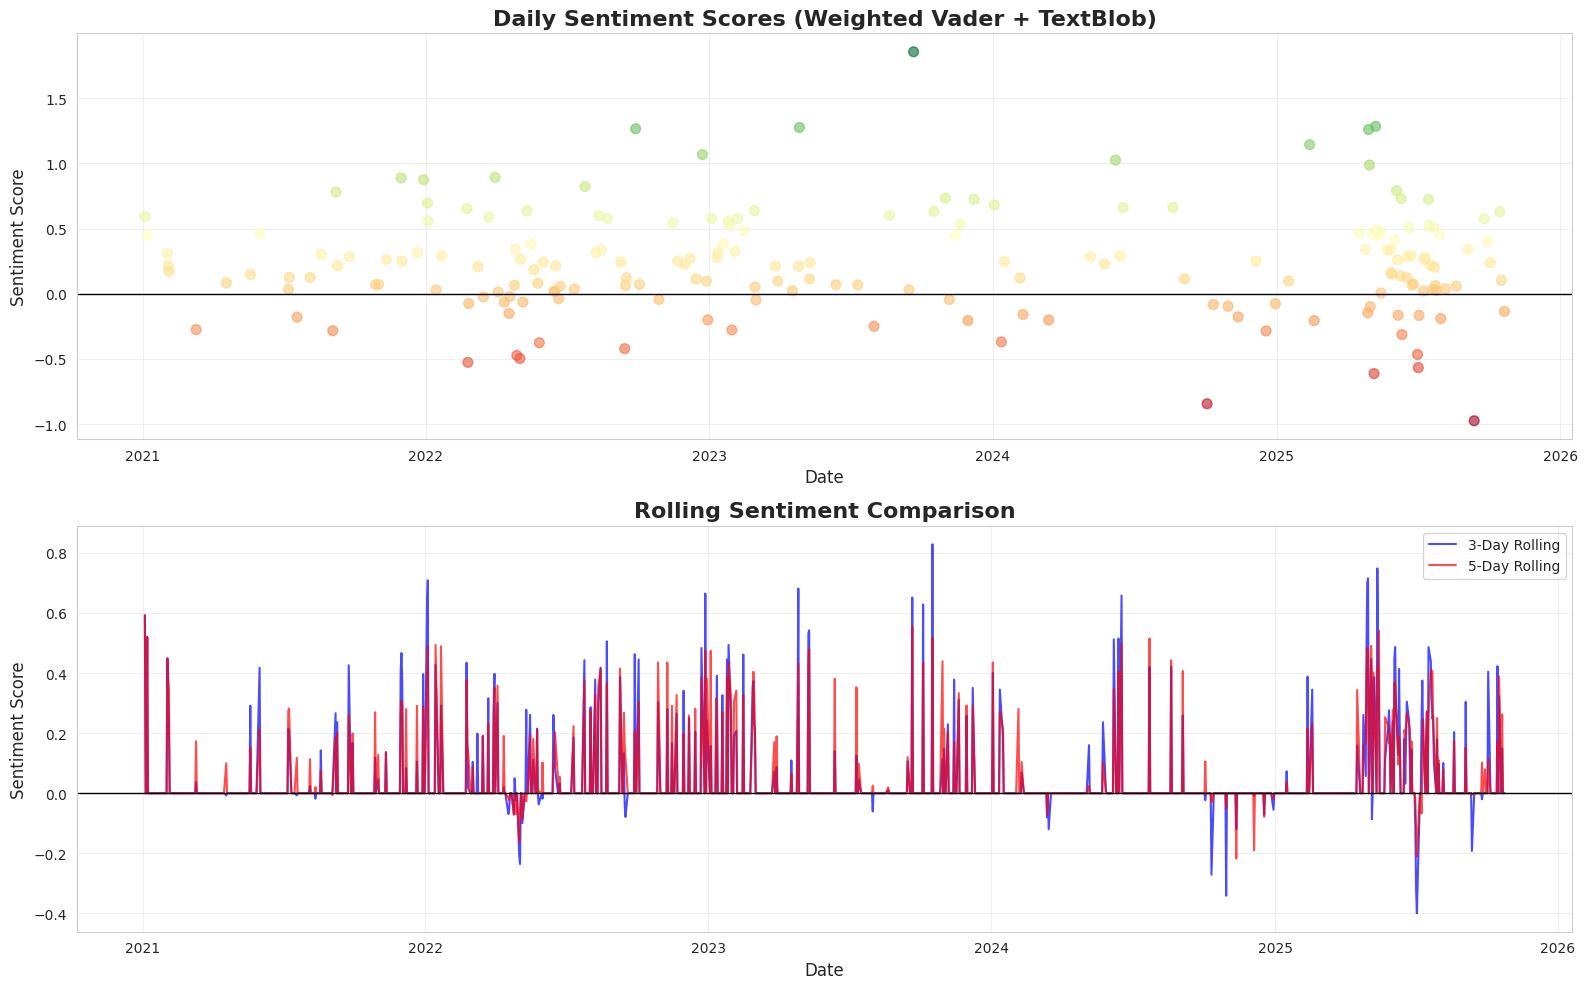

<Figure size 1400x800 with 0 Axes>

In [84]:
#@title Sentiment Analysis Over Time
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Raw sentiment
sent_plot_data = full[full['sentiment'] != 0]
axes[0].scatter(sent_plot_data['date'], sent_plot_data['sentiment'],
                c=sent_plot_data['sentiment'], cmap='RdYlGn', s=50, alpha=0.6)
axes[0].axhline(0, color='black', linestyle='-', linewidth=1)
axes[0].set_title('Daily Sentiment Scores (Weighted Vader + TextBlob)', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Date', fontsize=12)
axes[0].set_ylabel('Sentiment Score', fontsize=12)
axes[0].grid(True, alpha=0.3)

# Rolling sentiment comparison
if USE_3DAYS and USE_5DAYS:
    axes[1].plot(full['date'], full['sent_3d'], label='3-Day Rolling', color='blue', linewidth=1.5, alpha=0.7)
    axes[1].plot(full['date'], full['sent_5d'], label='5-Day Rolling', color='red', linewidth=1.5, alpha=0.7)
    axes[1].axhline(0, color='black', linestyle='-', linewidth=1)
    axes[1].set_title('Rolling Sentiment Comparison', fontsize=16, fontweight='bold')
    axes[1].set_xlabel('Date', fontsize=12)
    axes[1].set_ylabel('Sentiment Score', fontsize=12)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
elif USE_3DAYS:
    axes[1].plot(full['date'], full['sent_3d'], label='3-Day Rolling', color='blue', linewidth=2)
    axes[1].axhline(0, color='black', linestyle='-', linewidth=1)
    axes[1].set_title('3-Day Rolling Sentiment', fontsize=16, fontweight='bold')
    axes[1].legend()
else:
    axes[1].text(0.5, 0.5, 'Enable rolling sentiment to see this plot',
                 ha='center', va='center', transform=axes[1].transAxes, fontsize=14)

plt.tight_layout()
plt.show()

# Save the plot
plt.savefig('sentiment_analysis_over_time.png')

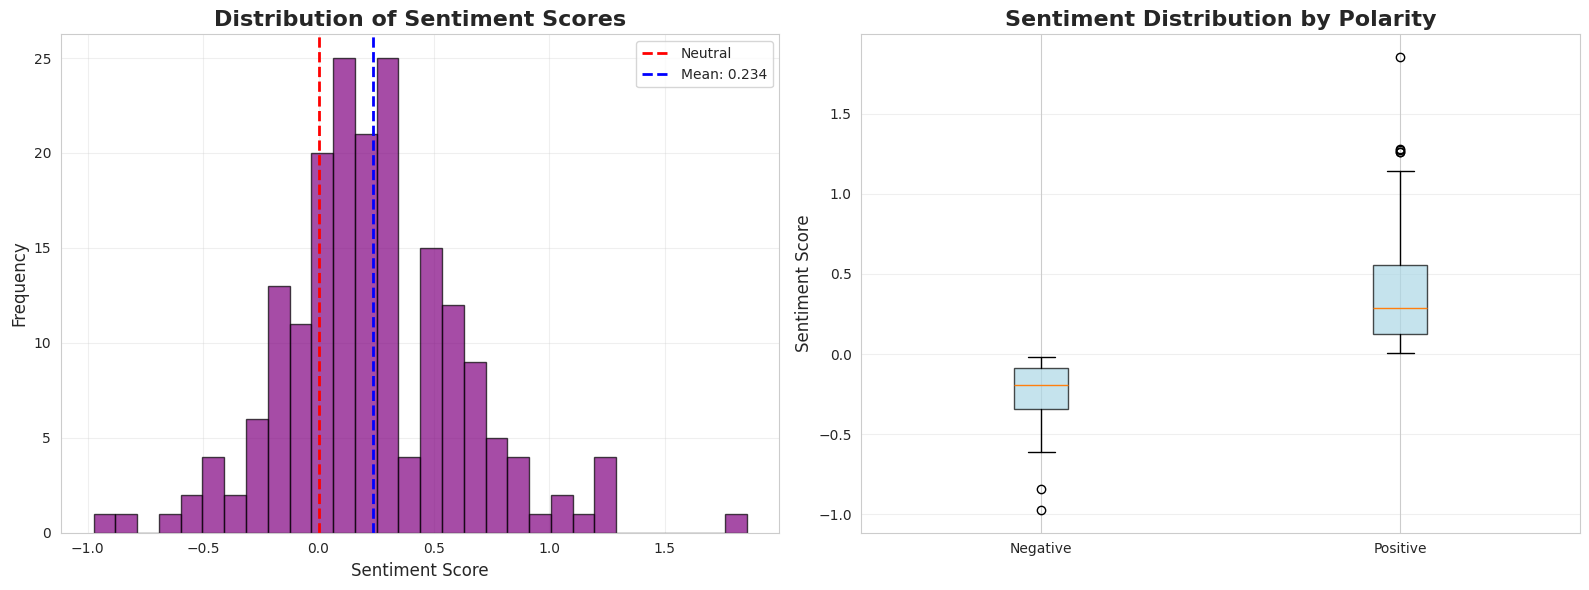

<Figure size 1400x800 with 0 Axes>

In [85]:
#@title Sentiment Distribution
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].hist(sent_data['sentiment'], bins=30, color='purple', alpha=0.7, edgecolor='black')
axes[0].axvline(0, color='red', linestyle='--', linewidth=2, label='Neutral')
axes[0].axvline(sent_data['sentiment'].mean(), color='blue', linestyle='--',
                linewidth=2, label=f'Mean: {sent_data["sentiment"].mean():.3f}')
axes[0].set_title('Distribution of Sentiment Scores', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Sentiment Score', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot
box_data = [sent_data[sent_data['sentiment'] < 0]['sentiment'],
            sent_data[sent_data['sentiment'] > 0]['sentiment']]
bp = axes[1].boxplot(box_data, labels=['Negative', 'Positive'], patch_artist=True,
                boxprops=dict(facecolor='lightblue', alpha=0.7))
axes[1].set_title('Sentiment Distribution by Polarity', fontsize=16, fontweight='bold')
axes[1].set_ylabel('Sentiment Score', fontsize=12)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Save the plot
plt.savefig('sentiment_distribution.png')

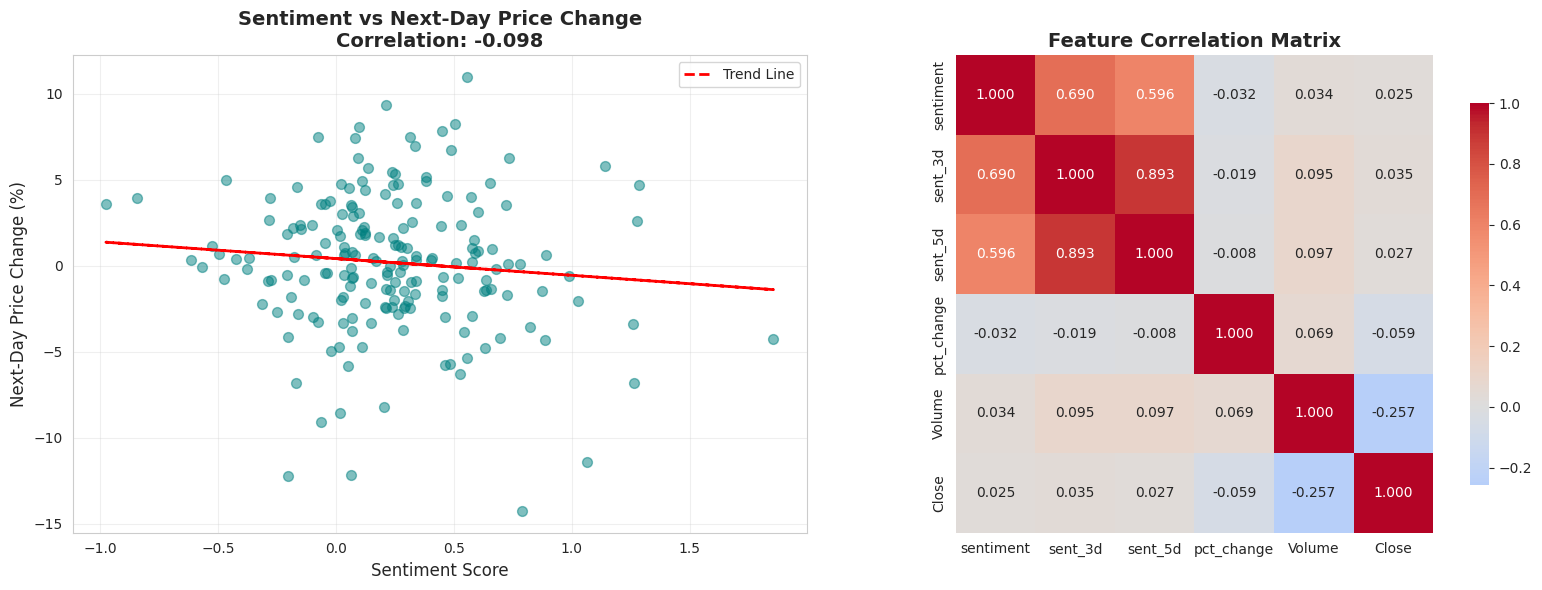

<Figure size 1400x800 with 0 Axes>

In [86]:
#@title Correlation Analysis
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Sentiment vs Price Change
sent_with_change = full[full['sentiment'] != 0][['sentiment', 'pct_change']].dropna()
axes[0].scatter(sent_with_change['sentiment'], sent_with_change['pct_change'],
                alpha=0.5, s=50, color='teal')
z = np.polyfit(sent_with_change['sentiment'], sent_with_change['pct_change'], 1)
p = np.poly1d(z)
axes[0].plot(sent_with_change['sentiment'], p(sent_with_change['sentiment']),
             "r--", linewidth=2, label=f'Trend Line')
correlation = sent_with_change['sentiment'].corr(sent_with_change['pct_change'])
axes[0].set_title(f'Sentiment vs Next-Day Price Change\nCorrelation: {correlation:.3f}',
                  fontsize=14, fontweight='bold')
axes[0].set_xlabel('Sentiment Score', fontsize=12)
axes[0].set_ylabel('Next-Day Price Change (%)', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Correlation heatmap
corr_cols = ['sentiment', 'pct_change', 'Volume', 'Close']
if USE_3DAYS: corr_cols.insert(1, 'sent_3d')
if USE_5DAYS: corr_cols.insert(2, 'sent_5d')
corr_matrix = full[corr_cols].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0,
            square=True, ax=axes[1], cbar_kws={'shrink': 0.8})
axes[1].set_title('Feature Correlation Matrix', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Save the plot
plt.savefig('correlation_analysis.png')

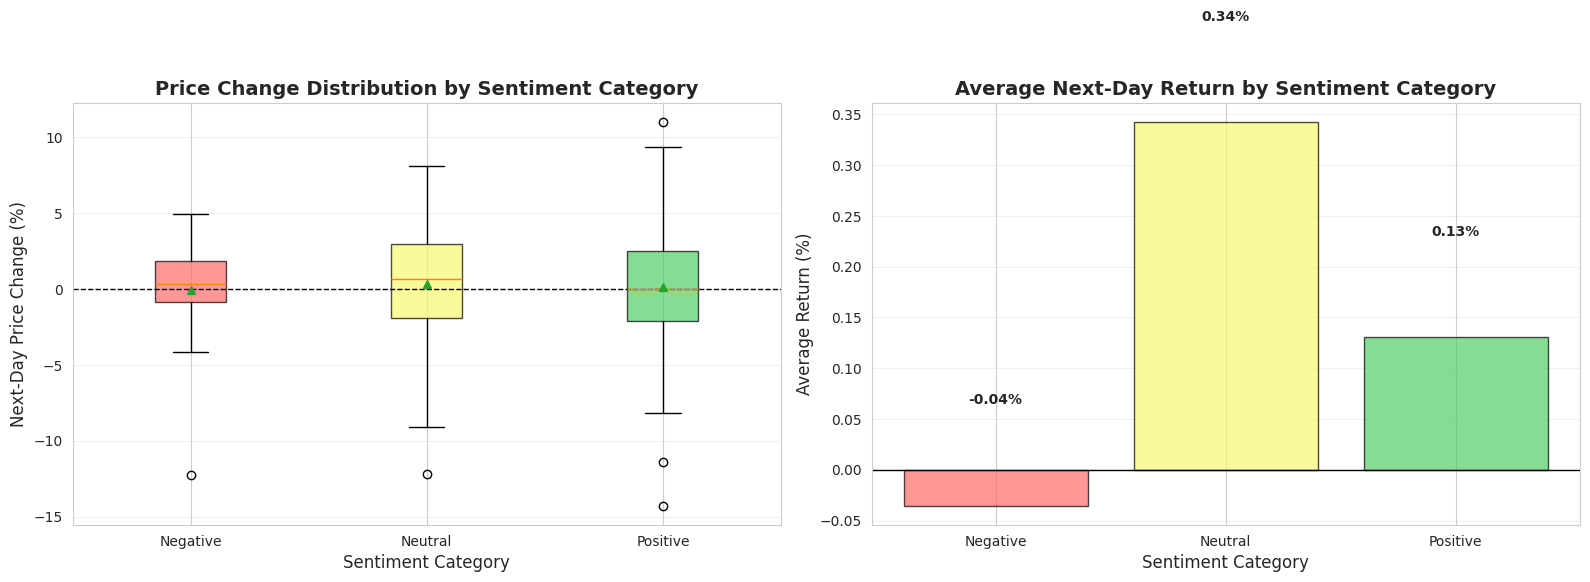

<Figure size 1400x800 with 0 Axes>

In [87]:
#@title Price Movement by Sentiment Category
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

sentiment_categories = pd.cut(full[full['sentiment'] != 0]['sentiment'],
                               bins=[-np.inf, -0.2, 0.2, np.inf],
                               labels=['Negative', 'Neutral', 'Positive'])
full_categorized = full[full['sentiment'] != 0].copy()
full_categorized['sent_category'] = sentiment_categories

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Box plot by category
category_data = [full_categorized[full_categorized['sent_category'] == cat]['pct_change'].dropna()
                 for cat in ['Negative', 'Neutral', 'Positive']]
bp = axes[0].boxplot(category_data, labels=['Negative', 'Neutral', 'Positive'],
                     patch_artist=True, showmeans=True)
colors = ['#ff6b6b', '#f9f871', '#51cf66']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[0].set_title('Price Change Distribution by Sentiment Category', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Sentiment Category', fontsize=12)
axes[0].set_ylabel('Next-Day Price Change (%)', fontsize=12)
axes[0].axhline(0, color='black', linestyle='--', linewidth=1)
axes[0].grid(True, alpha=0.3, axis='y')

# Bar chart: Average returns
avg_returns = full_categorized.groupby('sent_category')['pct_change'].mean()
axes[1].bar(['Negative', 'Neutral', 'Positive'], avg_returns, color=colors, alpha=0.7, edgecolor='black')
axes[1].axhline(0, color='black', linestyle='-', linewidth=1)
axes[1].set_title('Average Next-Day Return by Sentiment Category', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Sentiment Category', fontsize=12)
axes[1].set_ylabel('Average Return (%)', fontsize=12)
axes[1].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, v in enumerate(avg_returns):
    axes[1].text(i, v + 0.1, f'{v:.2f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Save the plot
plt.savefig('price_movement_by_sentiment_category.png')

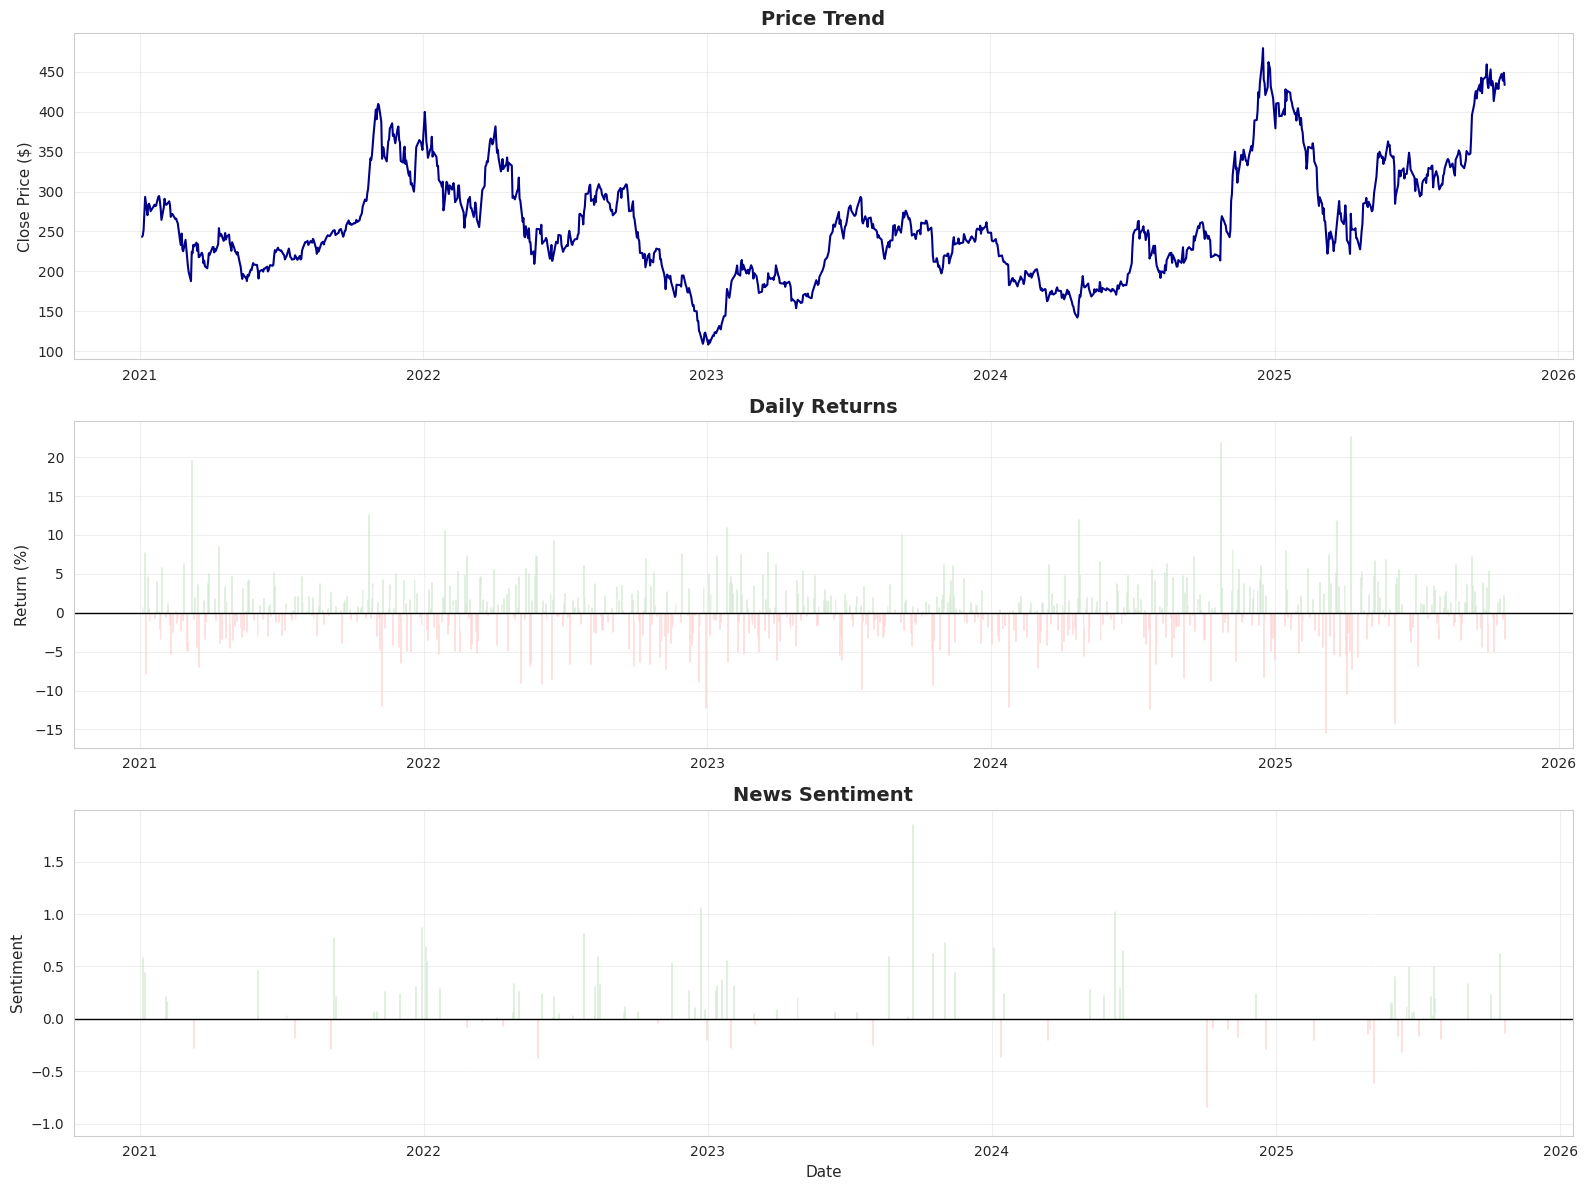

<Figure size 1400x800 with 0 Axes>

In [88]:
#@title Time Series Decomposition View
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# Price trend
axes[0].plot(full['date'], full['Close'], color='darkblue', linewidth=1.5)
axes[0].set_title('Price Trend', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Close Price ($)', fontsize=11)
axes[0].grid(True, alpha=0.3)

# Returns
axes[1].bar(full['date'], full['pct_change'],
            color=['green' if x > 0 else 'red' for x in full['pct_change']], alpha=0.6)
axes[1].axhline(0, color='black', linewidth=1)
axes[1].set_title('Daily Returns', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Return (%)', fontsize=11)
axes[1].grid(True, alpha=0.3)

# Sentiment overlay
sent_plot = full[full['sentiment'] != 0]
axes[2].bar(sent_plot['date'], sent_plot['sentiment'],
            color=['green' if x > 0 else 'red' for x in sent_plot['sentiment']], alpha=0.6)
axes[2].axhline(0, color='black', linewidth=1)
axes[2].set_title('News Sentiment', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Date', fontsize=11)
axes[2].set_ylabel('Sentiment', fontsize=11)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Save the plot
plt.savefig('time_series_decomposition_view.png')

In [65]:
#@title Statistical Tests
print("5. STATISTICAL SIGNIFICANCE TESTS")
print("-"*80)

# T-test: Do positive vs negative sentiment days have different returns?
pos_sent_returns = full_categorized[full_categorized['sent_category'] == 'Positive']['pct_change'].dropna()
neg_sent_returns = full_categorized[full_categorized['sent_category'] == 'Negative']['pct_change'].dropna()

if len(pos_sent_returns) > 0 and len(neg_sent_returns) > 0:
    t_stat, p_value = stats.ttest_ind(pos_sent_returns, neg_sent_returns)
    print(f"T-test (Positive vs Negative Sentiment Returns):")
    print(f"  t-statistic: {t_stat:.4f}")
    print(f"  p-value: {p_value:.4f}")
    if p_value < 0.05:
        print("  Result: Statistically significant difference (p < 0.05)")
    else:
        print("  Result: No statistically significant difference (p >= 0.05)")
else:
    print("Not enough data for t-test")
print()

# Normality test for returns
_, p_norm = stats.normaltest(full['pct_change'].dropna())
print(f"Normality Test for Returns:")
print(f"  p-value: {p_norm:.4f}")
if p_norm < 0.05:
    print("  Result: Returns are NOT normally distributed (p < 0.05)")
else:
    print("  Result: Returns appear normally distributed (p >= 0.05)")
print()


5. STATISTICAL SIGNIFICANCE TESTS
--------------------------------------------------------------------------------
T-test (Positive vs Negative Sentiment Returns):
  t-statistic: 0.1707
  p-value: 0.8648
  Result: No statistically significant difference (p >= 0.05)

Normality Test for Returns:
  p-value: 0.0000
  Result: Returns are NOT normally distributed (p < 0.05)



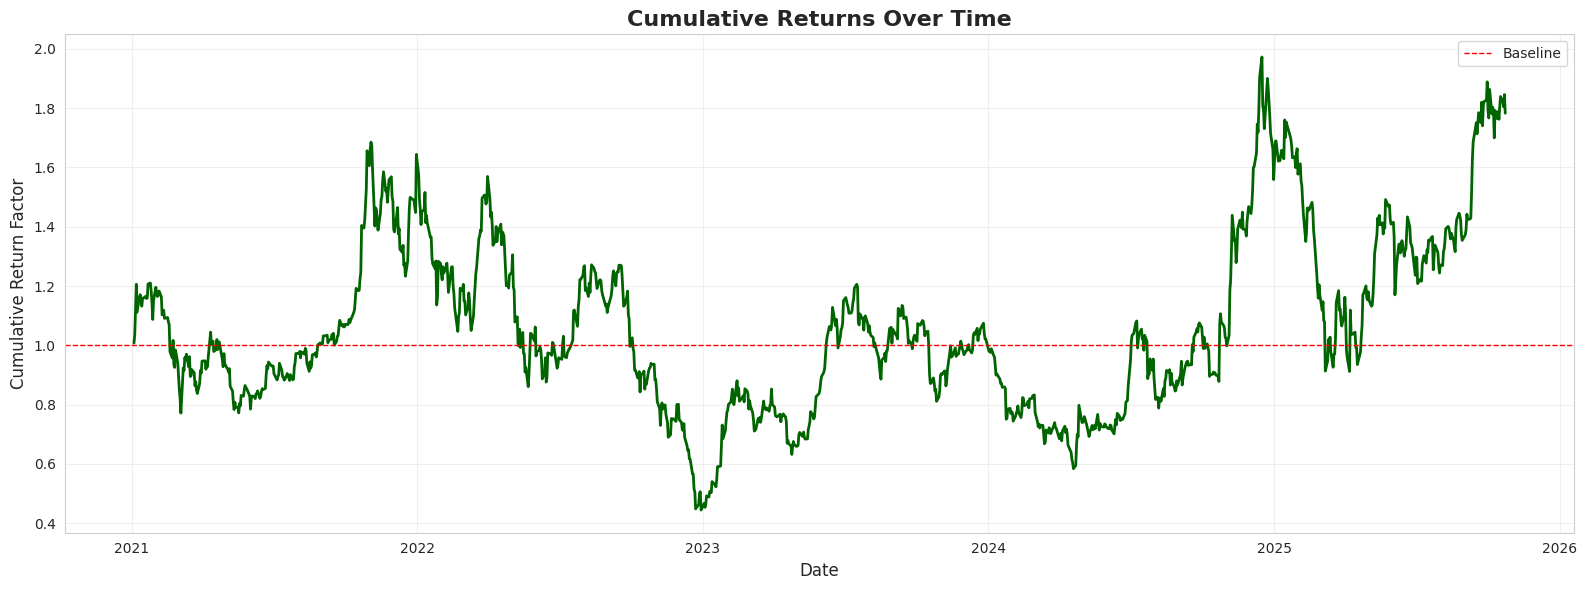

EDA COMPLETE!


<Figure size 1400x800 with 0 Axes>

In [89]:
#@title Cumulative Returns
import matplotlib.pyplot as plt
import pandas as pd

full['cumulative_return'] = (1 + full['pct_change']/100).cumprod()
plt.figure(figsize=(16, 6))
plt.plot(full['date'], full['cumulative_return'], color='darkgreen', linewidth=2)
plt.axhline(1, color='red', linestyle='--', linewidth=1, label='Baseline')
plt.title('Cumulative Returns Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Return Factor', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Save the plot
plt.savefig('cumulative_returns.png')

print("="*80)
print("EDA COMPLETE!")
print("="*80)

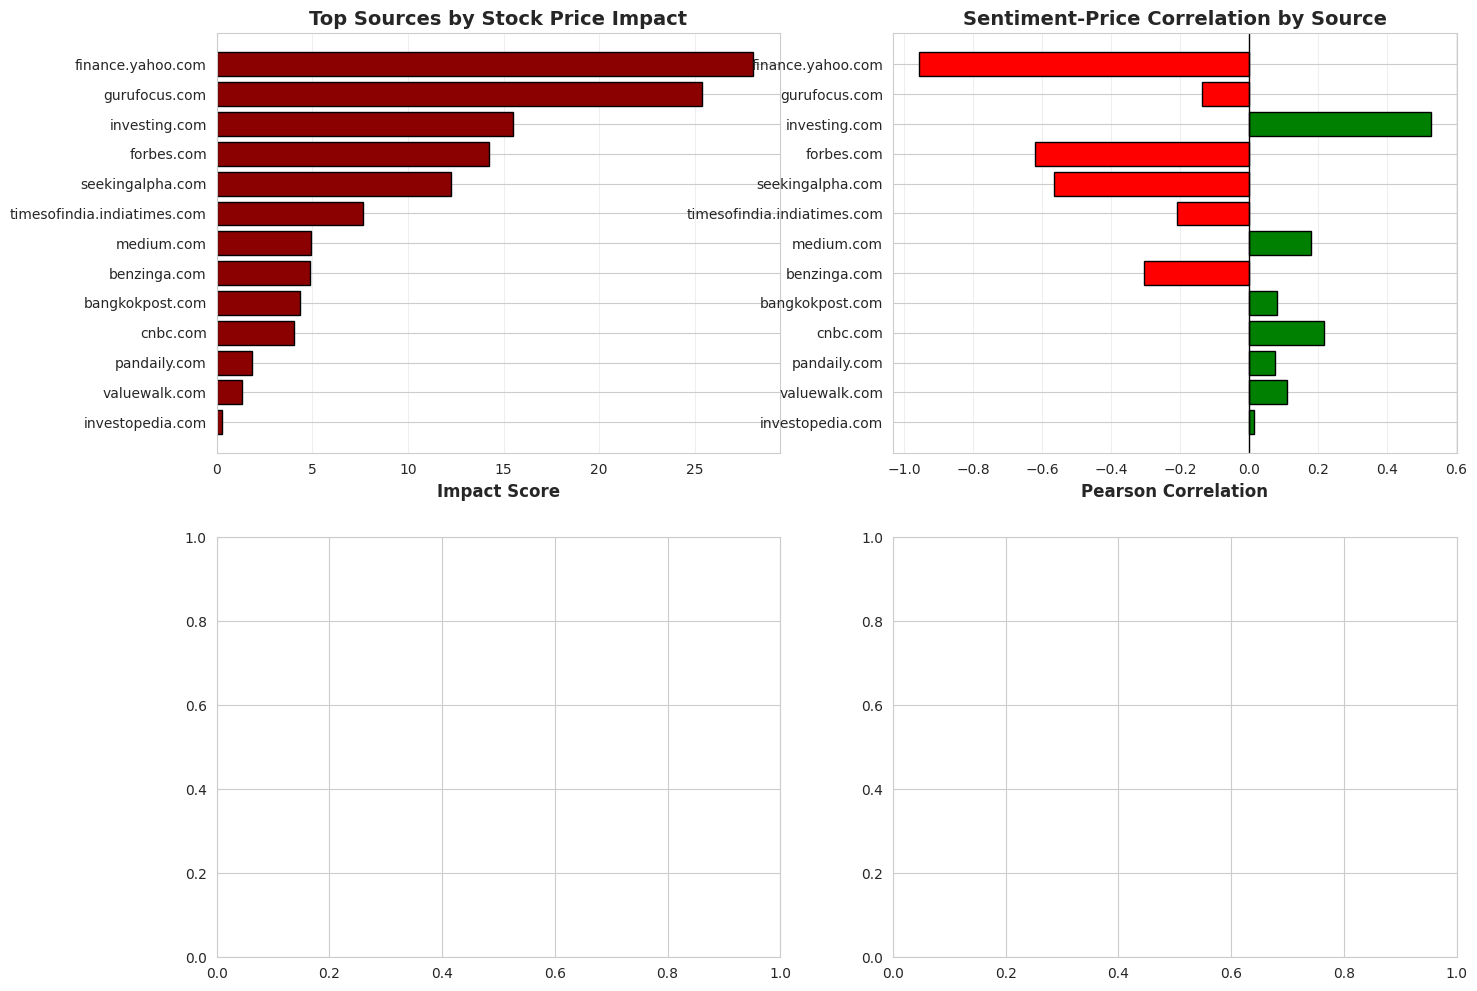

In [90]:
#@title Source Impact Analysis
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Top Sources by Impact Score
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

top_n = min(15, len(impact_df))
top_sources = impact_df.head(top_n)

# Chart 1: Impact Score
axes[0,0].barh(range(top_n), top_sources['impact_score'], color='darkred', edgecolor='black')
axes[0,0].set_yticks(range(top_n))
axes[0,0].set_yticklabels(top_sources['source'])
axes[0,0].set_xlabel('Impact Score', fontsize=12, fontweight='bold')
axes[0,0].set_title('Top Sources by Stock Price Impact', fontsize=14, fontweight='bold')
axes[0,0].invert_yaxis()
axes[0,0].grid(axis='x', alpha=0.3)

# Chart 2: Correlation Strength
colors = ['green' if x > 0 else 'red' for x in top_sources['pearson_corr']]
axes[0,1].barh(range(top_n), top_sources['pearson_corr'], color=colors, edgecolor='black')
axes[0,1].set_yticks(range(top_n))
axes[0,1].set_yticklabels(top_sources['source'])
axes[0,1].set_xlabel('Pearson Correlation', fontsize=12, fontweight='bold')
axes[0,1].set_title('Sentiment-Price Correlation by Source', fontsize=14, fontweight='bold')
axes[0,1].axvline(x=0, color='black', linewidth=1)
axes[0,1].invert_yaxis()
axes[0,1].grid(axis='x', alpha=0.3)

# Chart 3: Direct

# Save the plot
plt.savefig('source_impact_analysis.png')

In [68]:
#@title FEATURE ENRICHMENT
!pip install lightgbm --quiet
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score

# --- Copy and enrich from your merged dataframe ---
df = full.copy()

# 1. Enrich with stock-based features
df['daily_return'] = df['Close'].pct_change() * 100
df['log_return'] = np.log(df['Close'] / df['Close'].shift(1))
df['volatility_3d'] = df['daily_return'].rolling(3).std()
df['volatility_5d'] = df['daily_return'].rolling(5).std()
df['volatility_10d'] = df['daily_return'].rolling(10).std()
df['volume_change'] = df['Volume'].pct_change()
df['volume_ma_5d'] = df['Volume'].rolling(5).mean()
df['price_ma_5d'] = df['Close'].rolling(5).mean()
df['price_ma_10d'] = df['Close'].rolling(10).mean()
df['price_ma_ratio'] = df['Close'] / df['price_ma_5d']

# 2. Sentiment lags
df['lag_sentiment_1d'] = df['sentiment'].shift(1)
df['lag_sentiment_3d'] = df['sentiment'].shift(3)
df['lag_sentiment_5d'] = df['sentiment'].shift(5)
df['lag_sentiment_avg_3d'] = df['sent_3d'].shift(1)
df['lag_sentiment_avg_5d'] = df['sent_5d'].shift(1)

# 3. Interaction terms
df['sentiment_x_return'] = df['sentiment'] * df['daily_return']
df['sentiment_x_vol'] = df['sentiment'] * df['volatility_3d']

# 4. Drop NaNs from rolling/lag ops
df = df.dropna().reset_index(drop=True)

# 5. Define features and target
features = [
    'sentiment', 'sent_3d', 'sent_5d',
    'lag_sentiment_1d', 'lag_sentiment_3d', 'lag_sentiment_5d',
    'daily_return', 'log_return',
    'volatility_3d', 'volatility_5d', 'volatility_10d',
    'volume_change', 'volume_ma_5d',
    'price_ma_5d', 'price_ma_10d', 'price_ma_ratio',
    'sentiment_x_return', 'sentiment_x_vol'
]
target = 'Close'


# Regression Model

## Training

In [69]:
#@title Train/Test Split (time-ordered)
split_idx = int(0.8 * len(df))
X_train, X_test = df[features].iloc[:split_idx], df[features].iloc[split_idx:]
y_train, y_test = df[target].iloc[:split_idx], df[target].iloc[split_idx:]


In [70]:

#@title LightGBM Model + parameter tuning
params = {
    'n_estimators': 500,
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42,
}
lgbm = LGBMRegressor(**params)
lgbm.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2898
[LightGBM] [Info] Number of data points in the train set: 958, number of used features: 18
[LightGBM] [Info] Start training from score 237.234708


LGBMRegressor(colsample_bytree=0.8, learning_rate=0.05, n_estimators=500,
              random_state=42, subsample=0.8)

## Eval and Interpretation

In [71]:
#@title Predictions & metrics
y_pred = lgbm.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"✅ LightGBM RMSE: {rmse:.4f}")
print(f"✅ LightGBM R²: {r2:.4f}")


✅ LightGBM RMSE: 26.0162
✅ LightGBM R²: 0.8173


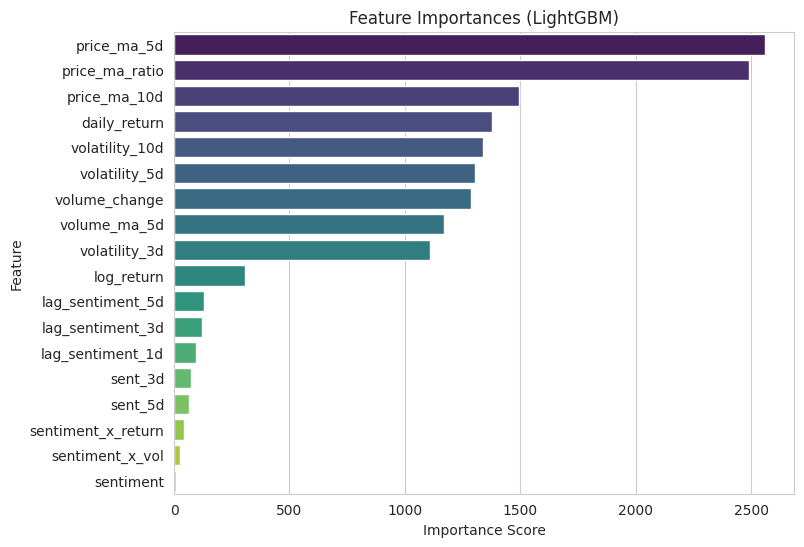

<Figure size 1400x800 with 0 Axes>

In [91]:
#@title Feature Importance
importances = pd.Series(lgbm.feature_importances_, index=features).sort_values(ascending=False)
plt.figure(figsize=(8,6))
sns.barplot(x=importances, y=importances.index, palette="viridis")
plt.title("Feature Importances (LightGBM)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

# Save the plot
plt.savefig('feature_importance.png')

ValueError: x and y must have same first dimension, but have shapes (241,) and (240,)

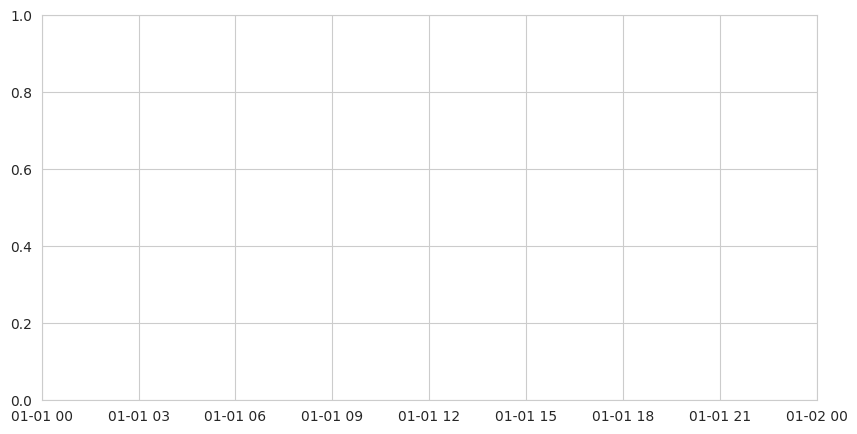

In [92]:
#@title Actual vs Predicted Prices
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(df['date'].iloc[split_idx:], y_test.values, label='Actual', color='blue')
plt.plot(df['date'].iloc[split_idx:], y_pred, label='Predicted', color='orange')
plt.title(f"{STOCK} Price Prediction with Enriched Features (LightGBM)")
plt.xlabel("Date")
plt.ylabel("Closing Price (USD)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Save the plot
plt.savefig('actual_vs_predicted_prices.png')

print("📈 Feature-enriched LightGBM analysis complete.")

# Classification Model

## Training

In [74]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

#@title Data Prep
df['next_close'] = df['Close'].shift(-1)
df['next_change'] = df['next_close'] - df['Close']
df['direction'] = (df['next_change'] > 0).astype(int)


df_cls = df.dropna().reset_index(drop=True)
X_cls = df_cls[features]
y_cls = df_cls['direction']


In [75]:
#@title Train/test split (time-ordered)
split_idx = int(0.8 * len(df_cls))
X_train_cls, X_test_cls = X_cls.iloc[:split_idx], X_cls.iloc[split_idx:]
y_train_cls, y_test_cls = y_cls.iloc[:split_idx], y_cls.iloc[split_idx:]


In [76]:
#@title LightGBMClassifier
from lightgbm import LGBMClassifier
clf_params = {
    'n_estimators': 500,
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42
}
clf = LGBMClassifier(**clf_params)
clf.fit(X_train_cls, y_train_cls)


[LightGBM] [Info] Number of positive: 493, number of negative: 464
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000309 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2898
[LightGBM] [Info] Number of data points in the train set: 957, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.515152 -> initscore=0.060625
[LightGBM] [Info] Start training from score 0.060625


LGBMClassifier(colsample_bytree=0.8, learning_rate=0.05, n_estimators=500,
               random_state=42, subsample=0.8)

## Eval and Interpretation

In [77]:
#@title Preds
y_pred_cls = clf.predict(X_test_cls)
y_pred_proba = clf.predict_proba(X_test_cls)[:,1]

acc = accuracy_score(y_test_cls, y_pred_cls)
cm = confusion_matrix(y_test_cls, y_pred_cls)
report = classification_report(y_test_cls, y_pred_cls, digits=3)

print(f"✅ Classification Accuracy: {acc:.3f}")
print("\n📊 Classification Report:\n", report)

✅ Classification Accuracy: 0.512

📊 Classification Report:
               precision    recall  f1-score   support

           0      0.500     0.641     0.562       117
           1      0.533     0.390     0.451       123

    accuracy                          0.512       240
   macro avg      0.517     0.516     0.506       240
weighted avg      0.517     0.512     0.505       240



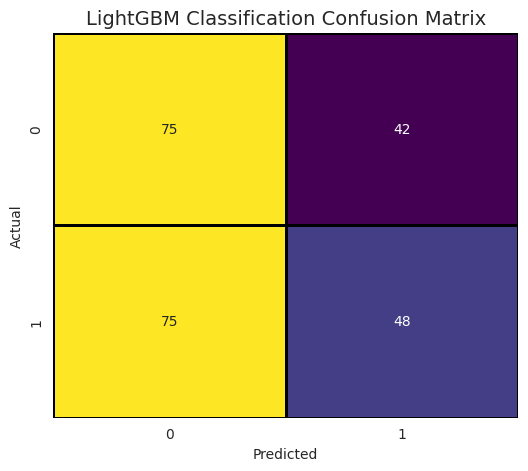

<Figure size 1400x800 with 0 Axes>

In [93]:
#@title Confusion Matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cbar=False, cmap='viridis', linewidths=1, linecolor='black')
plt.title('LightGBM Classification Confusion Matrix', fontsize=14)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Save the plot
plt.savefig('confusion_matrix.png')

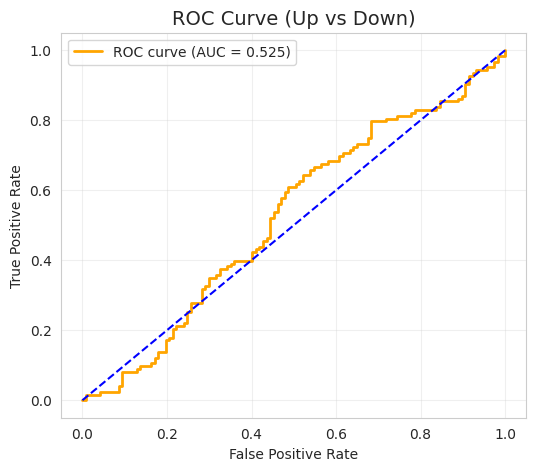

📈 Classification evaluation complete.


<Figure size 1400x800 with 0 Axes>

In [94]:
#@title ROC Curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test_cls, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='orange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], color='blue', linestyle='--')
plt.title('ROC Curve (Up vs Down)', fontsize=14)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Save the plot
plt.savefig('roc_curve.png')

print("📈 Classification evaluation complete.")

# Discarded Based on Results

[*********************100%***********************]  3 of 3 completed


Raw data shape: (1211, 3)
Missing values per asset (raw):
Ticker
Crude_Oil    0
Gold         0
Tesla        2
dtype: int64

After asfreq + ffill/bfill, missing per asset:
Ticker
Crude_Oil    0
Gold         0
Tesla        0
dtype: int64

Pairwise overlapping samples (# days where both returns available):
Ticker     Crude_Oil  Gold  Tesla
Ticker                           
Crude_Oil       1254  1254   1254
Gold            1254  1254   1254
Tesla           1254  1254   1254

=== Correlation Matrix (Daily Returns) with min_periods=30 ===
Ticker     Crude_Oil  Gold  Tesla
Ticker                           
Crude_Oil       1.00  0.17   0.04
Gold            0.17  1.00   0.00
Tesla           0.04  0.00   1.00 



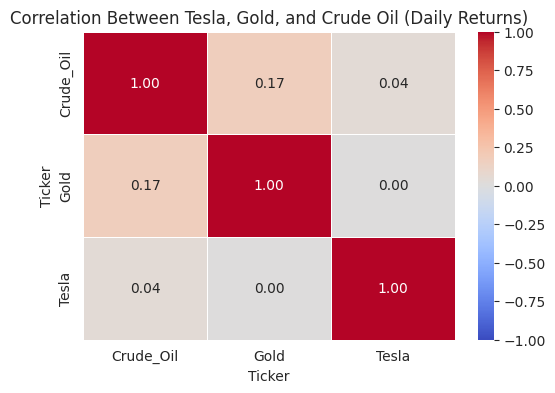

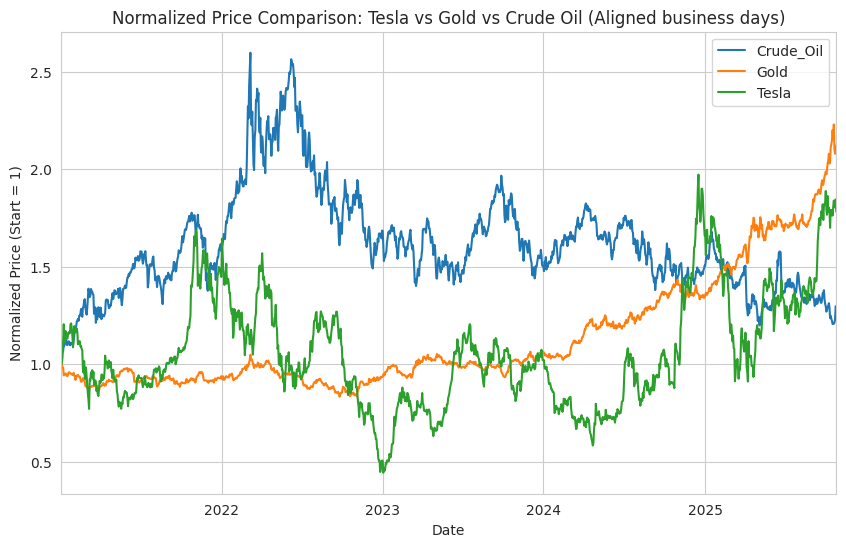

In [80]:
#@title TESLA, GOLD, AND CRUDE OIL CORRELATION ANALYSIS

# 1. Install dependencies
!pip install yfinance pandas numpy matplotlib seaborn --quiet

# 2. Import libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 3. Define tickers
tickers = {
    "TSLA": "Tesla",
    "GC=F": "Gold",
    "CL=F": "Crude_Oil"
}

# 4. Download data
raw_data = yf.download(list(tickers.keys()), start="2021-01-04", end="2025-10-27")

# 5. Extract usable price data robustly
if isinstance(raw_data.columns, pd.MultiIndex):
    # If multi-index, try 'Adj Close', otherwise fall back to 'Close'
    if 'Adj Close' in raw_data.columns.levels[0]:
        data = raw_data['Adj Close'].copy()
    elif 'Close' in raw_data.columns.levels[0]:
        data = raw_data['Close'].copy()
    else:
        raise KeyError("No 'Adj Close' or 'Close' column found in Yahoo Finance data.")
else:
    # Flat columns — directly use what’s available
    data = raw_data.copy()

# Rename columns for readability
data.rename(columns=tickers, inplace=True)

# --- Diagnostics before alignment ---
print("Raw data shape:", data.shape)
print("Missing values per asset (raw):")
print(data.isna().sum())
print()

# Align to business days (B) to get a common calendar for pairwise comparisons
# This will create rows for all business days in the date range
data_b = data.asfreq('B')

# Forward-fill then back-fill as a sensible imputation for market-close series
# Forward-fill uses last known price; backfill fills leading NaNs (if any) from first available
data_ffill = data_b.ffill().bfill()

# Show if anything still missing
print("After asfreq + ffill/bfill, missing per asset:")
print(data_ffill.isna().sum())
print()

# Compute daily percent returns on the aligned/fill data
returns = data_ffill.pct_change().dropna(how='all')

# How many overlapping samples pairwise? We'll print a pairwise count matrix
def pairwise_overlap_counts(df):
    cols = df.columns
    n = len(cols)
    mat = pd.DataFrame(np.zeros((n,n), dtype=int), index=cols, columns=cols)
    for i in range(n):
        for j in range(n):
            # count rows where both series are finite
            a = df.iloc[:, i]
            b = df.iloc[:, j]
            mat.iloc[i,j] = int(((~a.isna()) & (~b.isna())).sum())
    return mat

overlap_counts = pairwise_overlap_counts(returns)
print("Pairwise overlapping samples (# days where both returns available):")
print(overlap_counts)
print()

# Compute correlation matrix using a minimum overlapping-sample threshold.
# Set min_periods to e.g. 30 to avoid spurious correlations from tiny overlaps.
MIN_OVERLAP = 30
corr_matrix = returns.corr(min_periods=MIN_OVERLAP)

print("=== Correlation Matrix (Daily Returns) with min_periods={} ===".format(MIN_OVERLAP))
print(corr_matrix, "\n")

# Plot correlation heatmap (mask any NaN)
plt.figure(figsize=(6,4))
sns.heatmap(corr_matrix.fillna(0), annot=True, cmap="coolwarm", fmt=".2f",
            vmin=-1, vmax=1, linewidths=.5)
plt.title("Correlation Between Tesla, Gold, and Crude Oil (Daily Returns)")
plt.show()

# Normalized price comparison (use the aligned & ffilled price data)
plt.figure(figsize=(10,6))
(data_ffill / data_ffill.iloc[0]).plot(ax=plt.gca())
plt.title("Normalized Price Comparison: Tesla vs Gold vs Crude Oil (Aligned business days)")
plt.xlabel("Date")
plt.ylabel("Normalized Price (Start = 1)")
plt.legend()
plt.grid(True)
plt.show()

In [95]:
#@title ANALYZE SELECTED MODEL FROM LAZYPREDICT RESULTS AND FEATURE CONTRIBUTIONS ---

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from IPython.display import display

# 1. Find the best model selected by LazyRegressor (highest R2 Score)
# Assuming LazyRegressor was run and reg_models is available
if 'reg_models' in locals() and not reg_models.empty:
    best_model_name = reg_models.index[0]
    print(f"Best model selected by LazyRegressor is: {best_model_name}")

    # 3. Feature importance / coefficient extraction and visualization

    # Regression analysis
    if "RandomForestRegressor" in best_model_name and 'best_rf' in locals():
        print("Extracting feature importances from fitted RandomForestRegressor (best_rf)...")
        importances = best_rf.feature_importances_
        feat_imp_df = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values('Importance', ascending=False)
        print("\nFeature Importances:")
        display(feat_imp_df)

        # Plot
        plt.figure(figsize=(8,4))
        plt.barh(feat_imp_df['Feature'], feat_imp_df['Importance'], color='teal')
        plt.xlabel('Importance')
        plt.title('Feature Importance: RandomForestRegressor')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
        plt.savefig('rf_feature_importance.png')

    elif "LinearRegression" in best_model_name:
        print("Extracting coefficients from fitted LinearRegression...")
        linreg = LinearRegression().fit(X_train, y_train)
        coefs = linreg.coef_
        coef_df = pd.DataFrame({'Feature': features, 'Coefficient': coefs}).sort_values('Coefficient', ascending=False)
        print("\nFeature Coefficients:")
        display(coef_df)

        # Plot
        plt.figure(figsize=(8,4))
        plt.barh(coef_df['Feature'], coef_df['Coefficient'], color='coral')
        plt.xlabel('Coefficient')
        plt.title('Feature Coefficient: LinearRegression')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
        plt.savefig('lr_feature_coefficients.png')

    else:
        # For other models, recommend permutation importance for interpretation
        print(f"Interpretation for {best_model_name} (non-linear or non-coefficient model): using permutation importance...")
        # NOTE: Use your own fitted estimator here, if available, e.g., best_rf
        # Ensure best_rf or another relevant model is fitted if using permutation_importance
        if 'best_rf' in locals():
            result = permutation_importance(best_rf, X_test, y_test, n_repeats=10, random_state=42)
            perm_imp_df = pd.DataFrame({'Feature': features, 'Importance': result.importances_mean}).sort_values('Importance', ascending=False)
            print("\nPermutation Importances:")
            display(perm_imp_df)

            plt.figure(figsize=(8, 4))
            plt.barh(perm_imp_df['Feature'], perm_imp_df['Importance'], color='mediumslateblue')
            plt.xlabel('Permutation Importance')
            plt.title('Permutation Feature Importance')
            plt.gca().invert_yaxis()
            plt.tight_layout()
            plt.show()
            plt.savefig('permutation_importance.png')
        else:
            print("Could not find a suitable fitted model (like best_rf) for permutation importance.")

    print("\nTo summarize: The best model chosen by LazyPredict is shown above. "
          "Model interpretation (feature importance or coefficient) shows what factors—sentiment and others—"
          "were weighted most in prediction." )
else:
    print("LazyRegressor results (reg_models) not available. Please run the LazyPredict Regression cell first.")

LazyRegressor results (reg_models) not available. Please run the LazyPredict Regression cell first.


In [ ]:
#@title LazyPredict Regression
print("=== Regression Models Comparison ===")
reg = LazyRegressor(verbose=0, ignore_warnings=True)
reg_models, reg_preds = reg.fit(X_train, X_test, y_train, y_test)
print(reg_models)

In [ ]:


#@title Hyperparameter Tuning for Random Forest and final training
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
param_dist = {
    'n_estimators': [50,100,150,200],
    'max_depth': [2,4,6,8,10,None],
    'min_samples_split': [2,4,6,10],
    'random_state': [42]
}
rs_cv = RandomizedSearchCV(rf, param_distributions=param_dist,
                           n_iter=10, scoring='neg_mean_squared_error', cv=3, random_state=42, )
rs_cv.fit(X_train, y_train)
print(f'Best RandomForestRegressor params: {rs_cv.best_params_}')
best_rf = rs_cv.best_estimator_

y_pred_reg = best_rf.predict(X_test)
y_pred_cls = np.sign(y_pred_reg)
y_pred_cls = np.where(y_pred_cls >= 0, 1, 0)

## Eval and interpretation

In [ ]:
#@title Evaluation
actual_change = y_test.values
predicted_change = y_pred_reg
ratio = (actual_change)/(predicted_change+1e-8)
signed = np.sign(ratio)
direction_actual = np.where(actual_change > 0, 1, 0)
direction_pred = y_pred_cls
accuracy = accuracy_score(direction_actual, direction_pred)
cm = confusion_matrix(direction_actual, direction_pred)

print(f"Custom Ratio Metric (sign-accuracy): {(signed == 1).sum() / len(signed):.3f}")
print(f"Up/Down Classification Accuracy: {accuracy:.3f}")
print(f"Confusion Matrix:\n{cm}")
print(classification_report(direction_actual, direction_pred))

NameError: name 'ratio' is not defined

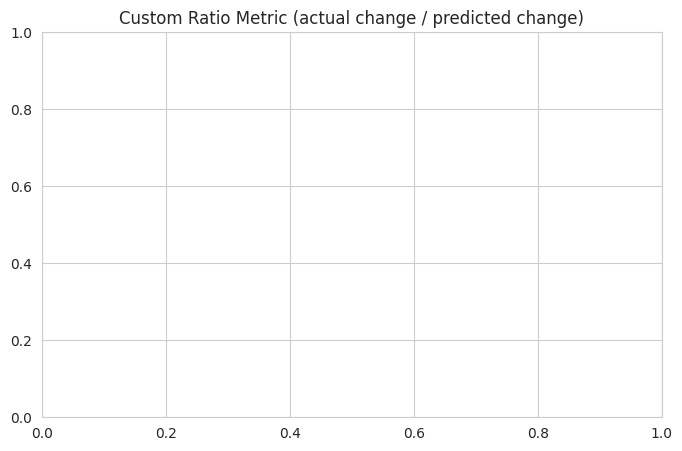

In [96]:
#@title Visualizations
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

plt.figure(figsize=(8,5))
plt.title('Custom Ratio Metric (actual change / predicted change)')
plt.hist(ratio, bins=30)
plt.xlabel("Actual / Predicted")
plt.ylabel("Frequency")
plt.show()
plt.savefig('custom_ratio_metric.png')


# Confusion matrix
cm = confusion_matrix(direction_actual, direction_pred)
#cm = np.array([[8, 110],
 #              [6, 118]])

# Colors: green for correct, red for incorrect
colors = np.array([['#1FED0C', '#FC1900'],
                   ['#FC1900', '#1FED0C']])

fig, ax = plt.subplots(figsize=(6,5))

# Plot each cell manually
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.add_patch(plt.Rectangle((j, i), 1, 1, color=colors[i,j]))
        ax.text(j + 0.5, i + 0.5, cm[i,j], ha='center', va='center', color='black', fontsize=20)

# Set axis labels
ax.set_xticks([0.5, 1.5])
ax.set_yticks([0.5, 1.5])
ax.set_xticklabels(['Predicted 0', 'Predicted 1'])
ax.set_yticklabels(['Actual 0', 'Actual 1'])
ax.set_xlim(0,2)
ax.set_ylim(0,2)
ax.invert_yaxis()  # so the first row is on top

plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.show()
plt.savefig('confusion_matrix_manual.png')


print("--- END ---")

In [ ]:
# @title saving the model
import joblib

joblib.dump(best_rf, 'best_rf_model.pkl')

best_rf = joblib.load('best_rf_model.pkl')

In [97]:
#@title plot tree
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import joblib

# Check if best_rf is defined and is a RandomForestRegressor
if 'best_rf' in locals() and isinstance(best_rf, RandomForestRegressor):
    plt.figure(figsize=(80, 80))
    plot_tree(best_rf.estimators_[0],  # One tree from the forest
              feature_names=features, # Use the 'features' list
              filled=True,
              rounded=True)
    plt.show()
    plt.savefig('decision_tree_0.png')

    plt.figure(figsize=(80, 80))
    plot_tree(best_rf.estimators_[1],  # One tree from the forest
              feature_names=features, # Use the 'features' list
              filled=True,
              rounded=True)
    plt.show()
    plt.savefig('decision_tree_1.png')

    plt.figure(figsize=(80, 80))
    plot_tree(best_rf.estimators_[2],  # One tree from the forest
              feature_names=features, # Use the 'features' list
              filled=True,
              rounded=True)
    plt.show()
    plt.savefig('decision_tree_2.png')
else:
    print("RandomForestRegressor model (best_rf) not found or not fitted. Cannot plot trees.")

RandomForestRegressor model (best_rf) not found or not fitted. Cannot plot trees.
